### Exploration

The main goal of this notebook is to enable exploration and testing, before the actual python scripts are properly written. Hence, we will download the data and test all recommender system algorithms we are aiming at:

* Collaborative Filtering;

* Matrix Factorization;

* Content-Based.

We will attempt to use the whole 20M movielens dataset, instead of using just a slice of it. In order to achieve it, we need to carefully choose the right data strucutres for each strategy and approach.

### Libraries

In [1]:
from typing import Any, List, Optional, Tuple
from tqdm import tqdm
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import boto3

### Data

In [2]:
FILES = ["movies.csv", "ratings.csv"]

In [3]:
bucket_name = "data-ml-gfluz94"
target_folder = "../data"

missing_files = (
    set(filter(lambda x: x.split(".")[-1] == "csv", os.listdir(target_folder))) - 
    set(FILES)
)

if len(missing_files) > 0:

    client = boto3.client(
        "s3", aws_access_key_id=os.environ["AWS_ACCESS_KEY"], aws_secret_access_key=os.environ["AWS_SECRET_KEY"]
    )
    content_response = client.list_objects(Bucket=bucket_name)

    for content in content_response["Contents"]:
        client.download_file(
            Bucket=bucket_name,
            Key=content["Key"],
            Filename=os.path.join(target_folder, content["Key"]),
        )

In [4]:
df_movies = pd.read_csv(os.path.join(target_folder, "movies.csv"))
df_ratings = pd.read_csv(os.path.join(target_folder, "ratings.csv"))

In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
display(df_movies.head())
display(df_ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Adjusting and preprocessing the data

In [8]:
df_ratings["timestamp"] = df_ratings["timestamp"].apply(datetime.utcfromtimestamp)

In [9]:
display(df_ratings.head())

,userId,movieId,rating,timestamp
0,1,296,5.0,2006-05-17 15:34:04
1,1,306,3.5,2006-05-17 12:26:57
2,1,307,5.0,2006-05-17 12:27:08
3,1,665,5.0,2006-05-17 15:13:40
4,1,899,3.5,2006-05-17 12:21:50


In [10]:
n_users = df_ratings.userId.nunique()
n_movies = df_ratings.movieId.nunique()

print(f"Total users: {n_users}")
print(f"Total movies: {n_movies}")

Total users: 162541
Total movies: 59047


In a sense, the `movies` dataset contains metadata on the actual movie - the name and the genres. We will see later that the genres can be turned into useful features for a content-based approach, however for now we are mostly concerned with the `ratings` dataset.

Since we have roughly 25M entries (~1GB), it will be impossible to fit all this data into memory in a matrix representation - users vs. ratings. Especially because the dimensionality (162,541 x 59,047) is high and there is **high sparsity** - a lot of 0s due to the fact that the users haven't watched a lot of movies.

Hence, we have some options to deal with this huge amount of data - and each one of them might be useful according to the chosen algorithm:

* **Dictionary**: With a dictionary representation, we can considerably reduce the dimensionality, since the movies that haven't been rated by the user won't be taken into account for that particular user;

* **Sparse Matrix**: `scipy` is a really useful tool for us to encode this information, which is computationally efficient for dealing with custom datasets being fed to neural networks.

### General EDA and Preprocessing

It might be useful to check for possible outliers in ratings, so that we have a more robust dataset for our training purposes.

count    162541.000000
mean        153.807932
std         268.047590
min          20.000000
1%           20.000000
5%           22.000000
10%          24.000000
25%          36.000000
50%          71.000000
75%         162.000000
90%         353.000000
95%         554.000000
99%        1228.000000
max       32202.000000
Name: n_movies_rated, dtype: float64

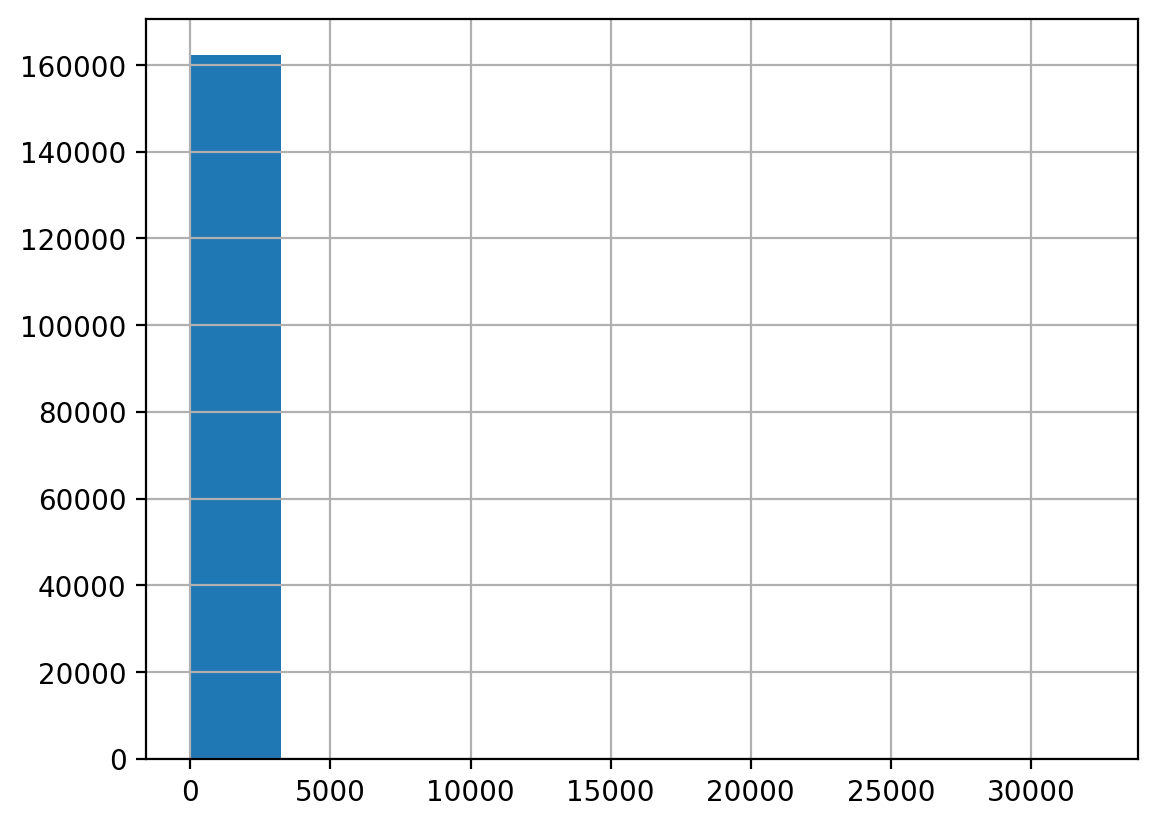

In [11]:
movies_rated_by_user = df_ratings.groupby("userId").agg({
    "movieId": pd.Series.nunique,
}).rename(columns={
    "movieId": "n_movies_rated",  
}).reset_index()

display(movies_rated_by_user["n_movies_rated"].describe(percentiles=[
    0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99 
]))
movies_rated_by_user["n_movies_rated"].hist();

We can clearly see that there is a user that has rated 32,202 movies!! That's more than 50% of the whole catalog. Hence, we are removing this user, in order not to pollute our analysis.

On the other hand, we do not need to worry much about users who have rated few movies, since the minimum # of ratings is 20 - which is pretty much reasonable.

In [12]:
movies_rated_by_user[movies_rated_by_user.n_movies_rated > 10_000]

,userId,n_movies_rated
72314,72315,32202


Before removing this particular user, let's take a look at the movies as well:

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
1%           1.000000
5%           1.000000
10%          1.000000
25%          2.000000
30%          2.000000
40%          4.000000
50%          6.000000
75%         36.000000
90%        413.000000
95%       1503.400000
99%       9941.620000
max      81491.000000
Name: n_ratings, dtype: float64

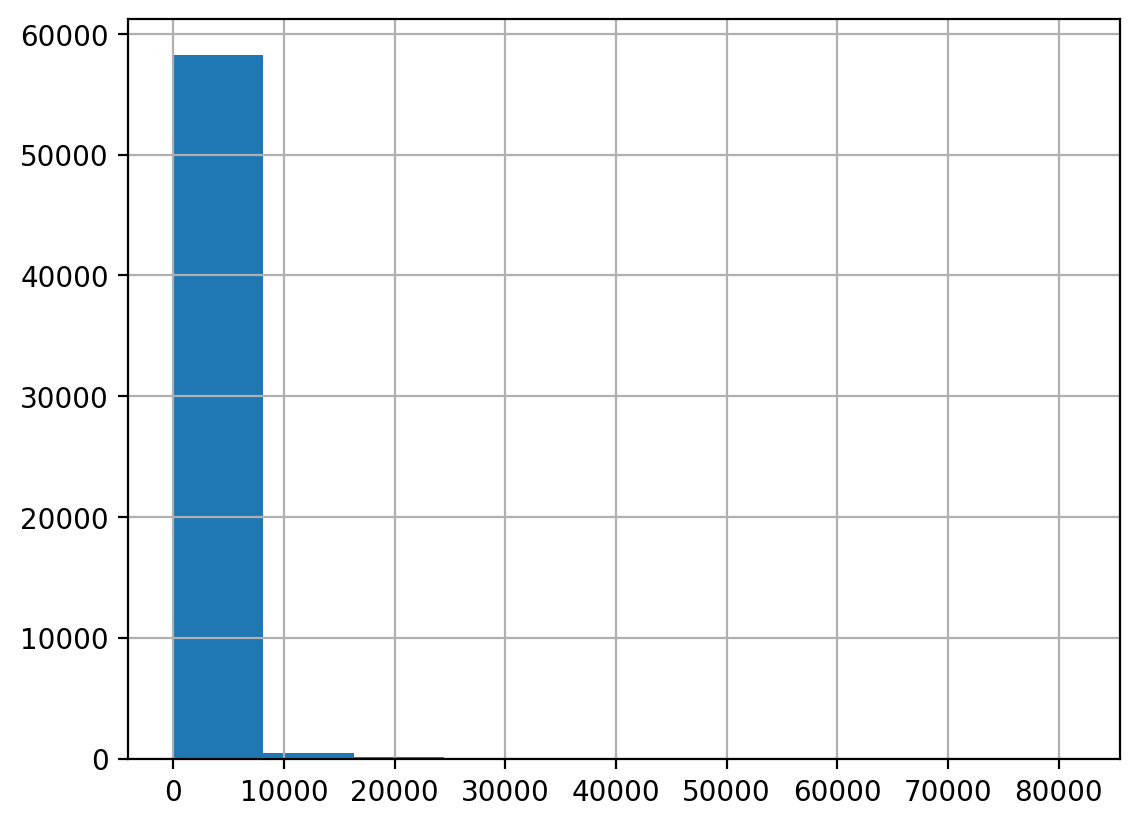

In [13]:
n_ratings_by_movie = df_ratings.groupby("movieId").agg({
    "userId": pd.Series.nunique,
}).rename(columns={
    "userId": "n_ratings",  
}).reset_index()

display(n_ratings_by_movie["n_ratings"].describe(percentiles=[
    0.01, 0.05, 0.10, 0.25, 0.30, 0.40, 0.75, 0.90, 0.95, 0.99 
]))
n_ratings_by_movie["n_ratings"].hist();

There are roughly 25% of movies with a single rating. Since these ratings could bias the whole system, due to the vision of a single user, let's remove some movies. In practice, let's keep only movies with **at least 3 ratings**.

On the other tail, we have a movie with ~80k ratings. Let's see which movie it is.

In [14]:
df_movies[df_movies["movieId"] == n_ratings_by_movie.loc[n_ratings_by_movie["n_ratings"] == 81491, "movieId"].iloc[0]]

,movieId,title,genres
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War


*Forrest Gump* is indeed an awesome movie. We need to be careful with this title, because it is very likely that this will be one of the top recommendations for users that haven't watched it yet.

Final functions for preprocessing:

In [15]:
def summarize_ratings(
    ratings_df: pd.DataFrame,
    agg_column: str,
    count_column: str,
    output_name: str,
) -> pd.DataFrame:
    return ratings_df.groupby(agg_column).agg({
        count_column: pd.Series.nunique,
    }).rename(columns={
        count_column: output_name,  
    }).reset_index()


def get_outliers(
    df: pd.DataFrame,
    values_column: str,
    target_column: str,
    lower_boundary: Optional[int] = None,
    upper_boundary: Optional[int] = None,
) -> List[Any]:
    to_remove = set()
    if lower_boundary:
        to_remove |= set(df.loc[df[values_column] <= lower_boundary, target_column].tolist())
    if upper_boundary:
        to_remove |= set(df.loc[df[values_column] >= upper_boundary, target_column].tolist())
    return list(to_remove)


def remove_extreme_movies_and_users(
    ratings_df: pd.DataFrame,
    movie_id_column: str,
    user_id_column: str,
    movie_ratings_boundaries: Tuple[Optional[int], Optional[int]] = (None, None),
    user_ratings_boundaries: Tuple[Optional[int], Optional[int]] = (None, None),
) -> pd.DataFrame:
    n_ratings = "n_ratings"
    target_columns = [movie_id_column, user_id_column]
    for target_column, boundaries in zip(
        target_columns, [movie_ratings_boundaries, user_ratings_boundaries]
    ):
        stats = summarize_ratings(
            ratings_df=ratings_df,
            agg_column=target_column,
            count_column=[column for column in target_columns if column != target_column][0],
            output_name=n_ratings,
        )
        lower, upper = boundaries
        to_remove = get_outliers(
            df=stats,
            values_column=n_ratings,
            target_column=target_column,
            lower_boundary=lower,
            upper_boundary=upper,
        )
        if to_remove:
            ratings_df = ratings_df[~ratings_df[target_column].isin(to_remove)].copy()
    
    return ratings_df

In [16]:
df_ratings = remove_extreme_movies_and_users(
    ratings_df=df_ratings,
    movie_id_column="movieId",
    user_id_column="userId",
    movie_ratings_boundaries=(3, None),
    user_ratings_boundaries=(None, 10_000),
)

In [17]:
n_users = df_ratings.userId.nunique()
n_movies = df_ratings.movieId.nunique()

print(f"Total users: {n_users}")
print(f"Total movies: {n_movies}")

Total users: 162540
Total movies: 36193


### Collaborative Filtering

There are three approaches we can follow:

* __User-User__: We evaluate users who are most similar to each user, based either on ratings or on views, and then recommend new movies to them;

* __Item-Item__: We evaluate items that are most similar to the items viewed or positively rated by each user, and then recommend them to the user base;

* __ALS__: With *Alternating Least Squares*, we are able to train a neural network that learns simultaneously latent representations for users and movies. As an example, we could infer some movie features (romantic, violent, good actors and actresses, etc.) and user features as well (how they like each genre).

Preparing the data is very important - we need to split it into a training and a test set, so that we can compute our metrics.

Since `timestamp` indicates the time when a given user watched the movie and rated it, it makes sense to respect the order of events, in order to be able to estimate the generalization capacity of our model accordingly.

In [18]:
train_size = 0.70

df_ratings = df_ratings.sort_values(by="timestamp")
time_cut = df_ratings.iloc[int(train_size * len(df_ratings))]["timestamp"].normalize()
print(f"OOT Set after {time_cut}")

df_train = df_ratings[df_ratings["timestamp"] <= time_cut]
df_test = df_ratings[df_ratings["timestamp"] > time_cut]

n_users = df_train.userId.nunique()
n_movies = df_train.movieId.nunique()
print(f"Train Set: {len(df_train)} entries | {n_users} users | {n_movies} movies")

n_users = df_test.userId.nunique()
n_movies = df_test.movieId.nunique()
print(f"Test Set: {len(df_test)} entries | {n_users} users | {n_movies} movies")

OOT Set after 2015-01-05 00:00:00
Train Set: 17450998 entries | 121760 users | 20744 movies
Test Set: 7484587 entries | 45371 users | 35711 movies


1) User-User

Here we have 162,540 different users, so that means quite a lot of computing overload. Hence, we need to optimize the computations by taking advantage of some data structure, such as dictionaries.

In [53]:
user_movies = df_train.groupby("userId").agg({"movieId": list})["movieId"].to_dict()

In [69]:
user_movie_ratings = {
    (int(user), int(movie)): rating
    for user, movie, rating in df_train[["userId", "movieId", "rating"]].values.tolist()
}

In [187]:
# Hyperparameters
minimum_movies_in_common = 5
maximum_similar_users = 25

# Helper for iteration over N/2 instead of N
user_user_similarities = {}

# For predictions
top_similar_users = {}
avg_rating_by_user = {}


users = list(user_movies.keys())

for idx, i in tqdm(enumerate(users)):
    movies_i = user_movies[i]
    set_movies_i = set(movies_i)
    ratings_i = {movie: user_movie_ratings[(i, movie)] for movie in set_movies_i}
    mean_rating_i = np.mean(list(ratings_i.values()))
    centered_ratings_i = {movie: rating - mean_rating_i for movie, rating in ratings_i.items()}

    avg_rating_by_user[i] = avg_rating_by_user.get(i, mean_rating_i)

    similar_users = {}
    for j in users[:idx] + users[idx+1:]:
        pair_i_j = (i, j) if i < j else (j, i)
        movies_j = user_movies[j]
        set_movies_j = set(movies_j)
        common_movies = set_movies_i & set_movies_j
        if len(common_movies) >= minimum_movies_in_common:
            if not pair_i_j in user_user_similarities:
                ratings_j = {movie: user_movie_ratings[(j, movie)] for movie in set_movies_j}
                mean_rating_j = np.mean(list(ratings_j.values()))
                avg_rating_by_user[j] = avg_rating_by_user.get(j, mean_rating_j)
                centered_ratings_j = {movie: rating - mean_rating_j for movie, rating in ratings_j.items()}
                user_user_similarities[pair_i_j] = np.corrcoef(
                    x=[rating for movie, rating in centered_ratings_i.items() if movie in common_movies],
                    y=[rating for movie, rating in centered_ratings_j.items() if movie in common_movies],
                )[0, 1]
            similar_users[j] = user_user_similarities[pair_i_j]

    top_similar_users[i] = [u for u, r in sorted(similar_users.items(), key=lambda x: -x[1])[:maximum_similar_users]]

0it [00:00, ?it/s]/Users/gfluz94/.recsys/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/gfluz94/.recsys/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
1it [01:32, 92.57s/it]


In [191]:
top_similar_users

{16388: [18283,
  43717,
  18074,
  18431,
  15353,
  17811,
  17604,
  82085,
  1992,
  2011,
  18529,
  15596,
  18305,
  17478,
  17159,
  106,
  1969,
  1364,
  1825,
  18859,
  15389,
  17289,
  17901,
  10626,
  17377]}

In [192]:
# PREDICTION
from functools import reduce

user = 16388

similar_users = top_similar_users[user]
watched_movies = user_movies[user]
movie_pool = set(
    reduce(lambda a, b: a+b, [user_movies[u] for u in similar_users])
)
predicted_ratings = {}
for movie in movie_pool:
    if not movie in watched_movies:
        ratings = []
        for similar_user in similar_users:
            if (similar_user, movie) in user_movie_ratings.keys():
                ratings.append(user_movie_ratings[(similar_user, movie)] - avg_rating_by_user[similar_user])
        predicted_ratings[movie] = np.mean(ratings) + avg_rating_by_user[user]

In [208]:
sorted(predicted_ratings.items(), key=lambda x: -x[1])[:10]

[(8949, 5.446843853820598),
 (58303, 5.446843853820598),
 (915, 5.427960438385458),
 (1235, 5.39922480620155),
 (4146, 5.325891472868217),
 (4388, 5.325891472868217),
 (89759, 5.325891472868217),
 (4006, 5.325891472868217),
 (370, 5.165891472868218),
 (2393, 5.065891472868217)]